In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import time

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_train_dataset = datasets.FashionMNIST('path', download=True, transform=transform)
test_dataset = datasets.FashionMNIST('path', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 12623349.71it/s]


Extracting path/FashionMNIST/raw/train-images-idx3-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203833.62it/s]


Extracting path/FashionMNIST/raw/train-labels-idx1-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3688102.36it/s]


Extracting path/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18940593.85it/s]

Extracting path/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to path/FashionMNIST/raw



In [ ]:
torch.manual_seed(42)
np.random.seed(42)
full_train_size = len(full_train_dataset)
sizes = [int(full_train_size * 0.01), int(full_train_size * 0.1), full_train_size - int(full_train_size * 0.11)]
train_subset_1, train_subset_10, _ = random_split(full_train_dataset, sizes)

In [ ]:
batch_sizes = [16, 100, 200]
data_loaders = {size: {batch_size: DataLoader(dataset, batch_size=batch_size, shuffle=True)
                      for batch_size in batch_sizes}
                for size, dataset in [('1%', train_subset_1), ('10%', train_subset_10), ('100%', full_train_dataset)]}

test_data_loaders = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
class SingleLayerNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_layers = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_layers(x)
    return logits

class TwoLayerNN(nn.Module):
  def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_layers = nn.Sequential(
      nn.Linear(input_size, hidden1_size),
      nn.ReLU(),
      nn.Linear(hidden1_size, hidden2_size),
      nn.ReLU(),
      nn.Linear(hidden2_size, output_size)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_layers(x)
    return logits

In [ ]:
def plot_costs(train_cost, test_cost, title, axis, pos):
  n = len(train_cost)
  axis[pos].plot(range(n), train_cost, label="Train cost")
  axis[pos].plot(range(n), test_cost, label="Test cost")
  axis[pos].set_title(title)
  axis[pos].set_xlabel("Epochs")
  if (pos == 0):
    axis[pos].set_ylabel("Cost")
  axis[pos].legend()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
input_size = 28 * 28
output_size = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def add_gaussian_noise(data, mean=0, std=1.0):
  noise = torch.randn_like(data) * std + mean
  noisy_data = data + noise
  return noisy_data

def train(model, optimizer, loss_fn, num_epochs, batch_size, train_loader, test_loader, train_noise, test_noise):
  train_cost_list = []
  test_cost_list = []
  best_acc = 0.0
  for epoch in range(num_epochs):
    torch.manual_seed(42)
    for phase in ["train", "test"]:
      if phase == "train":
        model.train()
        data_loader = train_loader
      else:
        model.eval()
        data_loader = test_loader

      total_loss = 0.0
      test_corrects = 0

      for i, (images, labels) in enumerate(data_loader):
        if (phase == "train" and train_noise) or (phase == "test" and test_noise):
          images = add_gaussian_noise(images)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          outputs = model(images)
          loss = criterion(outputs, labels)
          if phase == "train":
            loss.backward()
            optimizer.step()
          else:
            test_corrects += torch.sum(torch.argmax(outputs, dim=1) == labels)

        total_loss += loss.item()

      avg_loss = total_loss / len(data_loader)

      if phase == "train":
        train_cost_list.append(avg_loss)
      else:
        test_cost_list.append(avg_loss)
        acc = test_corrects / len(data_loader.dataset)
        if acc > best_acc:
          best_acc = acc

  return train_cost_list, test_cost_list, best_acc

Hidden size=10 :  tensor(0.8242, device='cuda:0')
Hidden size=50 :  tensor(0.8330, device='cuda:0')
Hidden size=200 :  tensor(0.8358, device='cuda:0')


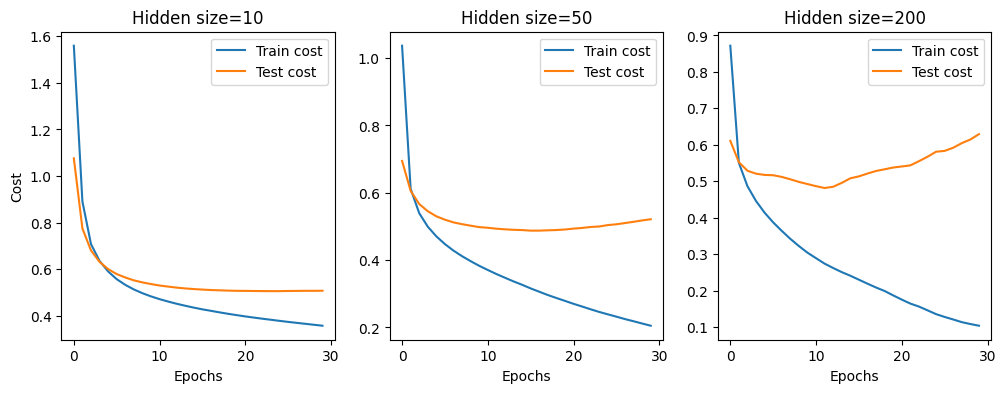

In [ ]:
train_size = "10%"
batch_size = 100
train_noise = False
test_noise = False

hidden_sizes = [10, 50, 200]
figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(hidden_sizes)):
  train_subset = data_loaders[train_size][batch_size]
  model = SingleLayerNN(input_size, hidden_sizes[i], output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, train_subset, test_data_loaders, train_noise, test_noise)
  title = "Hidden size=" + str(hidden_sizes[i])
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

Batch size=16 :  tensor(0.8250, device='cuda:0')
Batch size=100 :  tensor(0.8302, device='cuda:0')
Batch size=200 :  tensor(0.8343, device='cuda:0')


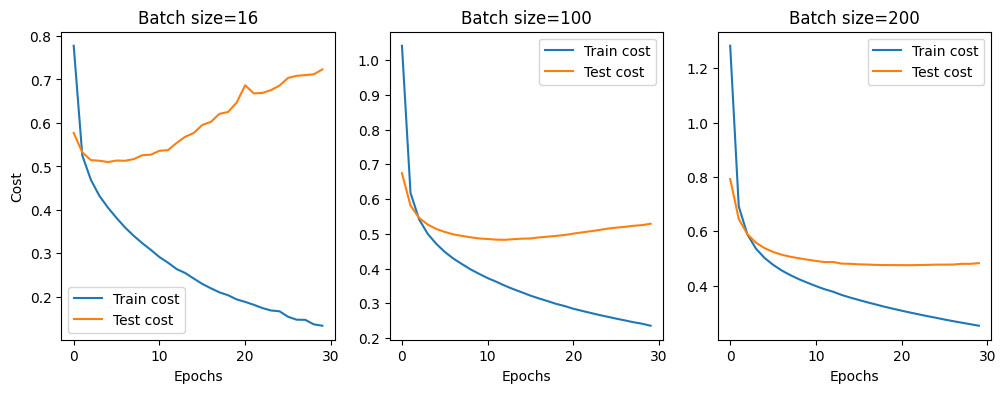

In [ ]:
hidden_size = 50
train_size = "10%"
train_noise = False
test_noise = False

batch_sizes = [16, 100, 200]
figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(batch_sizes)):
  train_subset = data_loaders[train_size][batch_sizes[i]]
  model = SingleLayerNN(input_size, hidden_size, output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_sizes[i], train_subset, test_data_loaders, train_noise, test_noise)
  title = "Batch size=" + str(batch_sizes[i])
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

Train size=1% :  tensor(0.7775, device='cuda:0')
Train size=10% :  tensor(0.8343, device='cuda:0')


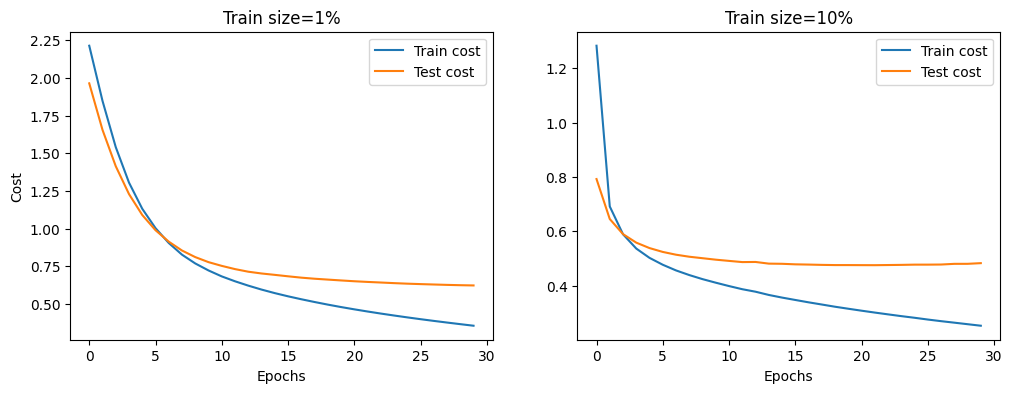

In [ ]:
hidden_size = 50
batch_size = 200
train_noise = False
test_noise = False

train_sizes = ["1%", "10%"]
figure, axis = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(train_sizes)):
  train_subset = data_loaders[train_sizes[i]][batch_size]
  model = SingleLayerNN(input_size, hidden_size, output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, train_subset, test_data_loaders, train_noise, test_noise)
  title = "Train size=" + str(train_sizes[i])
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

Noise in only test set :  tensor(0.7630, device='cuda:0')
Noise in both train and test sets :  tensor(0.7420, device='cuda:0')


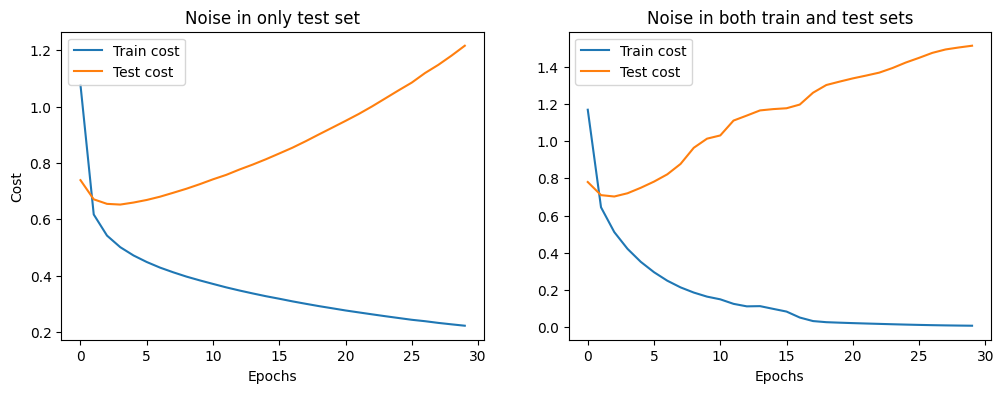

In [ ]:
hidden_size = 50
batch_size = 100
train_size = "10%"

data_disturbance = [{'train_noise': False, 'test_noise': True},
                    {'train_noise': True, 'test_noise': True}]
figure, axis = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(data_disturbance)):
  train_noise = data_disturbance[i]['train_noise']
  test_noise = data_disturbance[i]['test_noise']
  train_subset = data_loaders[train_size][batch_size]
  model = SingleLayerNN(input_size, hidden_size, output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, train_subset, test_data_loaders, train_noise, test_noise)
  if train_noise and test_noise:
    title = "Noise in both train and test sets"
  else:
    title = "Noise in only test set"
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

<h1>Experiments with two-layer NN</h1>

Hidden sizes=100, 200 :  tensor(0.8364, device='cuda:0')
Hidden sizes=200, 100 :  tensor(0.8389, device='cuda:0')
Hidden sizes=200, 200 :  tensor(0.8408, device='cuda:0')


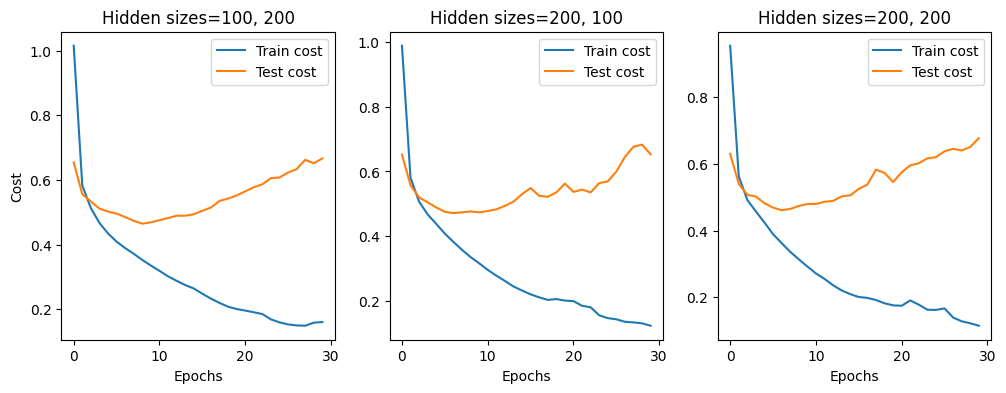

In [ ]:
train_size = "10%"
batch_size = 100
train_noise = False
test_noise = False

hidden_sizes = [{'hidden1_size': 100, 'hidden2_size': 200},
                {'hidden1_size': 200, 'hidden2_size': 100},
                {'hidden1_size': 200, 'hidden2_size': 200}]
figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(hidden_sizes)):
  hidden1_size, hidden2_size = hidden_sizes[i]['hidden1_size'], hidden_sizes[i]['hidden2_size']
  train_subset = data_loaders[train_size][batch_size]
  model = TwoLayerNN(input_size, hidden1_size, hidden2_size, output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, train_subset, test_data_loaders, train_noise, test_noise)
  title = "Hidden sizes=" + str(hidden1_size) + ", " + str(hidden2_size)
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

Batch size=16 :  tensor(0.8331, device='cuda:0')
Batch size=100 :  tensor(0.8364, device='cuda:0')
Batch size=200 :  tensor(0.8364, device='cuda:0')


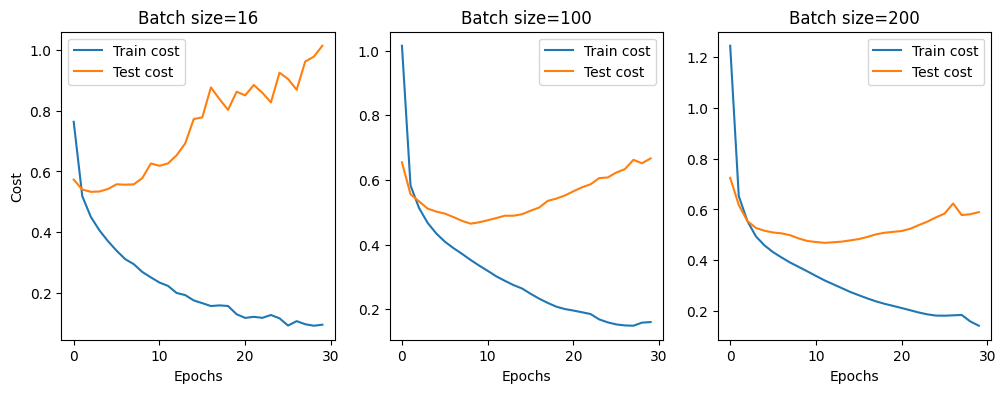

In [ ]:
train_size = "10%"
hidden1_size = 100
hidden2_size = 200
train_noise = False
test_noise = False

hidden_sizes = [{'hidden1_size': 100, 'hidden2_size': 200},
                {'hidden1_size': 200, 'hidden2_size': 100},
                {'hidden1_size': 200, 'hidden2_size': 200}]
batch_sizes = [16, 100, 200]
figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(batch_sizes)):
  train_subset = data_loaders[train_size][batch_sizes[i]]
  model = TwoLayerNN(input_size, hidden1_size, hidden2_size, output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_sizes[i], train_subset, test_data_loaders, train_noise, test_noise)
  title = "Batch size=" + str(batch_sizes[i])
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

Train size=1% :  tensor(0.7775, device='cuda:0')
Train size=10% :  tensor(0.8364, device='cuda:0')


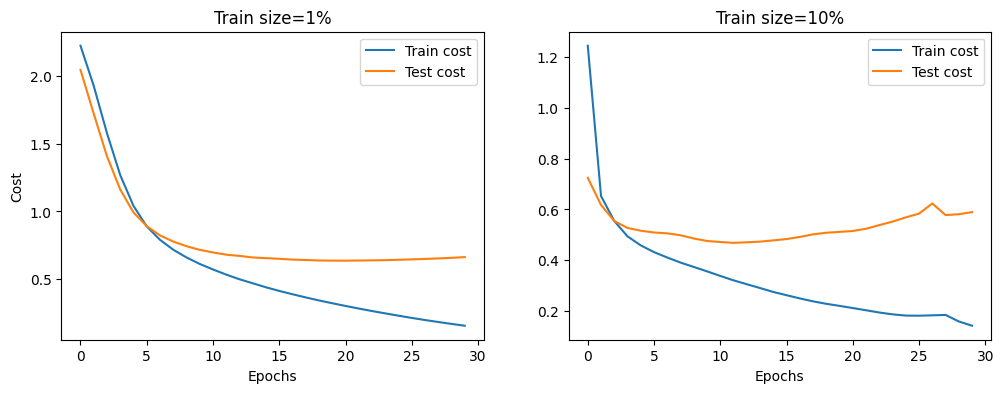

In [ ]:
hidden1_size = 100
hidden2_size = 200
batch_size = 200
train_noise = False
test_noise = False

train_sizes = ["1%", "10%"]
figure, axis = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(train_sizes)):
  train_subset = data_loaders[train_sizes[i]][batch_size]
  model = TwoLayerNN(input_size, hidden1_size, hidden2_size, output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, train_subset, test_data_loaders, train_noise, test_noise)
  title = "Train size=" + str(train_sizes[i])
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

No noise added :  tensor(0.8415, device='cuda:0')
Noise in only test set :  tensor(0.7575, device='cuda:0')
Noise in both train and test sets :  tensor(0.7385, device='cuda:0')


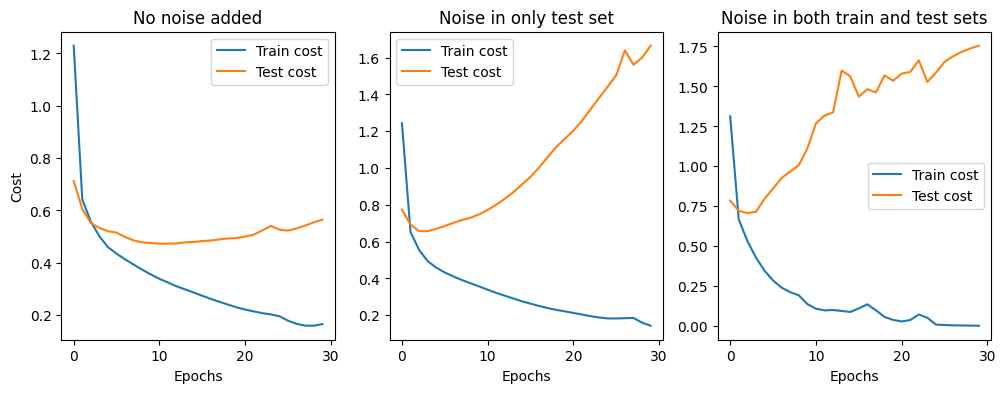

In [ ]:
train_size = "10%"
hidden1_size = 100
hidden2_size = 200
batch_size = 200
train_noise = False
test_noise = False

data_disturbance = [{'train_noise': False, 'test_noise': False},
                    {'train_noise': False, 'test_noise': True},
                    {'train_noise': True, 'test_noise': True}]
figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(data_disturbance)):
  train_noise = data_disturbance[i]['train_noise']
  test_noise = data_disturbance[i]['test_noise']
  train_subset = data_loaders[train_size][batch_size]
  model = TwoLayerNN(input_size, hidden1_size, hidden2_size, output_size).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, train_subset, test_data_loaders, train_noise, test_noise)
  if train_noise and test_noise:
    title = "Noise in both train and test sets"
  elif not train_noise and not test_noise:
    title = "No noise added"
  else:
    title = "Noise in only test set"
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)